In [4]:
from collections import defaultdict
from itertools import combinations
from ete3 import Tree
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import numpy as np
import ete3
import glob

In [5]:
## import gtdb genome information
genomes_all = pd.read_csv('../gtdb/bac120_metadata_r89.tsv', sep="\t")

In [6]:
## How many MAGs are completed? (1 contig) 
## How many MAGs are in 5 or fewer contigs?
mags_all = genomes_all[genomes_all.ncbi_genome_category == 'derived from metagenome']
print(mags_all[mags_all['scaffold_count'] == 1].shape[0])
print(mags_all[mags_all['scaffold_count'] <= 5].shape[0])

54
168


In [7]:
## filter to just the genomes those in the GTDB tree, with all SCGs we will be looking at

genomes = genomes_all[genomes_all['gtdb_representative'] == 't']

scgs_data = pd.read_csv('../gtdb/scgs_to_use.tsv', sep="\t")
print(scgs_data.shape)
scgs_data = scgs_data[scgs_data.ubiquity >= 93]
print(scgs_data.shape)

scgs = list(scgs_data['file'])
scg_count = defaultdict(int)

for scg in scgs:
    for seq in SeqIO.parse('../gtdb/genes/bac120_' + scg + ".faa", "fasta"):
        if len(str(seq.seq).replace("-","")) != 0:
            scg_count[seq.id] += 1

has_all_scg = set()

for genome in list(genomes['accession']):
    if scg_count[genome] == len(scgs):
        has_all_scg.add(genome)

genomes = genomes[genomes.accession.isin(has_all_scg)]

(35, 6)
(25, 6)


In [8]:
## How many CPR are in this set?
cpr = genomes[genomes['gtdb_taxonomy'].str.contains("Patescibacteria")]
cpr.shape[0]

212

In [9]:
## Total genome counts in this set
genomes['ncbi_genome_category'].value_counts()

none                                 9980
derived from metagenome              1902
derived from environmental_sample     200
derived from single cell               34
Name: ncbi_genome_category, dtype: int64

In [10]:
## Which SCGs are we using (chose SCGs that should be found in CPR too)
print(scgs_data['description'])

0                              ribosomal protein bS20
1                              ribosomal protein bL17
2                              ribosomal protein bL21
3                               ribosomal protein bL9
5     ribosomal RNA small subunit methyltransferase A
6                               ribosomal protein uS3
7                               ribosomal protein uS2
8                               ribosomal protein uS4
9                               ribosomal protein uS5
11                             ribosomal protein bL20
13                             ribosomal protein uL13
14                             ribosomal protein uL15
15                             ribosomal protein uL24
16                             ribosomal protein uL16
21                              ribosomal protein uL6
24                               alanine--tRNA ligase
26                               leucine--tRNA ligase
27                             histidine--tRNA ligase
28               preprotein 

In [11]:
## Create genome sets
mags = genomes[genomes.ncbi_genome_category == 'derived from metagenome']
sags = genomes[genomes.ncbi_genome_category == 'derived from single cell']
isolates = genomes[genomes.ncbi_genome_category == 'none']

In [ ]:
## make random sets of mags - I ran this off notebook

# mag_sets = []
# for i in range(1,20):
#     mag_sample = mags['accession'].sample(30)
#     mag_sets.append([mag_sample])

# ## make random sets of islates
# isolate_sets = []
# for i in range(1,20):
#     isolate_sample = isolates['accession'].sample(30)
#     isolate_sets.append([isolate_sample])

(2.4403217011494256, 2.46115)


In [435]:
## Read in my precalculate random samples of MAGs and isolates
genome_sets = {}
for run in glob.glob('../gtdb/genome_sets/set30/*'):
    f = open(run)
    line = f.readline().strip()
    genome_sets[run.split("/")[-1]] = line.split()[0].split(",")

In [436]:
## Get SCGs from each set and create alignment files for each
for genome_set_name in genome_sets:
    genome_set = genome_sets[genome_set_name]
    
    ## extract SCGs from each set
    scgs_set = defaultdict(dict)

    for scg in scgs:
        for seq in SeqIO.parse('../gtdb/genes/bac120_' + scg + ".faa", "fasta"):
            if seq.id in genome_set and len(str(seq.seq).replace("-","")) != 0:
                scgs_set[seq.id][scg] = seq.seq

    # create final fasta files
    for scg in scgs:
        f = open('../gtdb/trees/' + scg + "_" + genome_set_name + ".aln", "w+")
        for seq_id in scgs_set:
            if len(scgs_set[seq_id].keys()) == len(scgs):
                f.write(">" + seq_id + "\n")
                f.write(str(scgs_set[seq_id][scg]) + "\n") 
        f.close()

In [1]:
%%bash

## Run IQtree on each SCG for each sample of both MAGs and Isolates
## this will probably take a few hours to calculate all of these trees
## I ran it in parallel off notebook

cd ../gtdb/trees

for f in *.aln
do
iqtree -s $f -bb 1000 -nt 4 -m LG+G+I
done

IQ-TREE multicore version 1.6.7 for Linux 64-bit built Aug 23 2018
Developed by Bui Quang Minh, Nguyen Lam Tung, Olga Chernomor,
Heiko Schmidt, Dominik Schrempf, Michael Woodhams.

Host:    biotite (SSE4.2, 1007 GB RAM)
Command: iqtree -s *.aln -bb 1000 -nt 4 -m LG+G+I
Seed:    975531 (Using SPRNG - Scalable Parallel Random Number Generator)
Time:    Tue Aug 20 11:37:00 2019
Kernel:  SSE2 - 4 threads (80 CPU cores detected)

Reading alignment file *.aln ... 

ERROR: File not found *.aln


In [12]:
## Read in calculated phylogenetic trees
trees = defaultdict(list)
for fn in glob.glob('../gtdb/trees/set30/*.treefile'):
    scg = fn.split("/")[-1].split("_")[0]
    ttype = fn.split("/")[-1].split("_")[1].split(".")[0]
    trees[ttype].append(fn)

In [13]:
## Compare tree distances
distances = defaultdict(list)
for ttype in trees:
    for tree_pair in combinations(trees[ttype], 2):
        tree1 = Tree(tree_pair[0],quoted_node_names=True, format=1) 
        tree2 = Tree(tree_pair[1],quoted_node_names=True, format=1) 
        rf = tree1.robinson_foulds(tree2, unrooted_trees=True)
        if rf[1] != 0:
#             print(ttype + " RF distance is " + str(rf[0] / rf[1]))
            distances[ttype].append(rf[0] / rf[1])

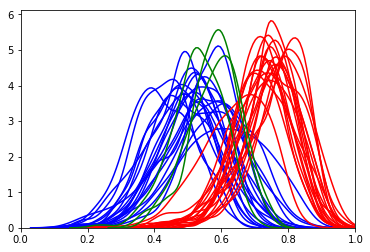

In [33]:
import matplotlib.pyplot as plt
for ttype in distances:
    if 'mag' in ttype:
        color = 'red'
    elif 'sag' in ttype:
        color = 'green'
    else:
        color = 'blue'
    sns.distplot(distances[ttype], hist=False, rug=False, color=color)

plt.xlim(0, 1)
plt.savefig("gtdb1.svg", format="svg")
plt.show()

# Create high quality MAG set

In [ ]:
## Create high quality MAG set
from random import sample
mags = mags[mags['scaffold_count'] <= 10]

for i in range(1,21):
        mag_sample = list(mags.sample(30)['accession'])
        f  = open('mag' + str(i), 'w+')
        f.write(str(",".join(mag_sample)) + "\t" + str((0,0)) + "\n")
        f.close()

In [ ]:
## Read in my precalculated random samples of MAGs and isolates
genome_sets = {}
for run in glob.glob('../gtdb/genome_sets/highqual/*'):
    f = open(run)
    line = f.readline().strip()
    genome_sets[run.split("/")[-1]] = line.split()[0].split(",")
    
## Get SCGs from each set and create alignment files for each
for genome_set_name in genome_sets:
    genome_set = genome_sets[genome_set_name]
    
    ## extract SCGs from each set
    scgs_set = defaultdict(dict)

    for scg in scgs:
        for seq in SeqIO.parse('../gtdb/genes/bac120_' + scg + ".faa", "fasta"):
            if seq.id in genome_set and len(str(seq.seq).replace("-","")) != 0:
                scgs_set[seq.id][scg] = seq.seq

    # create final fasta files
    for scg in scgs:
        f = open('../gtdb/trees/' + scg + "_" + genome_set_name + ".aln", "w+")
        for seq_id in scgs_set:
            if len(scgs_set[seq_id].keys()) == len(scgs):
                f.write(">" + seq_id + "\n")
                f.write(str(scgs_set[seq_id][scg]) + "\n") 
        f.close()

In [ ]:
%%bash

## Run IQtree on each SCG for each sample of both MAGs and Isolates
## this will probably take a few hours to calculate all of these trees
## I ran it in parallel off notebook

cd ../gtdb/trees

for f in *.aln
do
iqtree -s $f -bb 1000 -nt 4 -m LG+G+I
done

# Create matched genome sets (match by genus, by order)

In [ ]:
## Create genome sets matched by genus
tax_to_mag = {}


for index, row in mags.iterrows():
    tax_to_mag[row['gtdb_taxonomy'].split("g__")[1].split(";")[0]] = row['accession']

matched = 0
matches = []
tax_to_isolate = {}

for index, row in isolates.iterrows():
    genus = row['gtdb_taxonomy'].split("g__")[1].split(";")[0]
    if genus in tax_to_mag:
        if genus not in tax_to_isolate:
            matched += 1
            matches.append([tax_to_mag[genus], row['accession']])
            tax_to_isolate[genus] = row['accession']

print(matched)

from random import sample

for i in range(1,21):
        sampled = sample(matches, 30)
        isolate_sample = []
        mag_sample = []
        for sample_d in sampled:
                isolate_sample.append(sample_d[1])
                mag_sample.append(sample_d[0])

        f  = open('mag' + str(i), 'w+')
        f.write(str(",".join(mag_sample)) + "\t" + str((0,0)) + "\n")
        f.close()

        f = open('isolate' + str(i), 'w+')
        f.write(str(",".join(isolate_sample)) + "\t" + str((0,0)) + "\n")
        f.close()

In [ ]:
## Read in my precalculated random samples of MAGs and isolates
genome_sets = {}
for run in glob.glob('../gtdb/genome_sets/matched_genus/*'):
    f = open(run)
    line = f.readline().strip()
    genome_sets[run.split("/")[-1]] = line.split()[0].split(",")
    
## Get SCGs from each set and create alignment files for each
for genome_set_name in genome_sets:
    genome_set = genome_sets[genome_set_name]
    
    ## extract SCGs from each set
    scgs_set = defaultdict(dict)

    for scg in scgs:
        for seq in SeqIO.parse('../gtdb/genes/bac120_' + scg + ".faa", "fasta"):
            if seq.id in genome_set and len(str(seq.seq).replace("-","")) != 0:
                scgs_set[seq.id][scg] = seq.seq

    # create final fasta files
    for scg in scgs:
        f = open('../gtdb/trees/' + scg + "_" + genome_set_name + ".aln", "w+")
        for seq_id in scgs_set:
            if len(scgs_set[seq_id].keys()) == len(scgs):
                f.write(">" + seq_id + "\n")
                f.write(str(scgs_set[seq_id][scg]) + "\n") 
        f.close()

In [ ]:
%%bash

## Run IQtree on each SCG for each sample of both MAGs and Isolates
## this will probably take a few hours to calculate all of these trees
## I ran it in parallel off notebook

cd ../gtdb/trees

for f in *.aln
do
iqtree -s $f -bb 1000 -nt 4 -m LG+G+I
done

In [ ]:
## Create genome sets matched by order
tax_to_mag = {}


for index, row in mags.iterrows():
    tax_to_mag[row['gtdb_taxonomy'].split("o__")[1].split(";")[0]] = row['accession']

matched = 0
matches = []
tax_to_isolate = {}

for index, row in isolates.iterrows():
    genus = row['gtdb_taxonomy'].split("o__")[1].split(";")[0]
    if genus in tax_to_mag:
        if genus not in tax_to_isolate:
            matched += 1
            matches.append([tax_to_mag[genus], row['accession']])
            tax_to_isolate[genus] = row['accession']

print(matched)

from random import sample

for i in range(1,21):
        sampled = sample(matches, 30)
        isolate_sample = []
        mag_sample = []
        for sample_d in sampled:
                isolate_sample.append(sample_d[1])
                mag_sample.append(sample_d[0])

        f  = open('mag' + str(i), 'w+')
        f.write(str(",".join(mag_sample)) + "\t" + str((0,0)) + "\n")
        f.close()

        f = open('isolate' + str(i), 'w+')
        f.write(str(",".join(isolate_sample)) + "\t" + str((0,0)) + "\n")
        f.close()

In [ ]:
## Read in my precalculated random samples of MAGs and isolates
genome_sets = {}
for run in glob.glob('../gtdb/genome_sets/matched_order/*'):
    f = open(run)
    line = f.readline().strip()
    genome_sets[run.split("/")[-1]] = line.split()[0].split(",")
    
## Get SCGs from each set and create alignment files for each
for genome_set_name in genome_sets:
    genome_set = genome_sets[genome_set_name]
    
    ## extract SCGs from each set
    scgs_set = defaultdict(dict)

    for scg in scgs:
        for seq in SeqIO.parse('../gtdb/genes/bac120_' + scg + ".faa", "fasta"):
            if seq.id in genome_set and len(str(seq.seq).replace("-","")) != 0:
                scgs_set[seq.id][scg] = seq.seq

    # create final fasta files
    for scg in scgs:
        f = open('../gtdb/trees/' + scg + "_" + genome_set_name + ".aln", "w+")
        for seq_id in scgs_set:
            if len(scgs_set[seq_id].keys()) == len(scgs):
                f.write(">" + seq_id + "\n")
                f.write(str(scgs_set[seq_id][scg]) + "\n") 
        f.close()

In [ ]:
%%bash

## Run IQtree on each SCG for each sample of both MAGs and Isolates
## this will probably take a few hours to calculate all of these trees
## I ran it in parallel off notebook

cd ../gtdb/trees

for f in *.aln
do
iqtree -s $f -bb 1000 -nt 4 -m LG+G+I
done

# Results

In [17]:
## Read in calculated phylogenetic trees
trees = defaultdict(list)
for fn in glob.glob('../gtdb/trees/highqual/*.treefile'):
    scg = fn.split("/")[-1].split("_")[0]
    ttype = fn.split("/")[-1].split("_")[1].split(".")[0]
    trees[ttype].append(fn)

In [18]:
## Compare tree distances
distances_highqual = defaultdict(list)
for ttype in trees:
    for tree_pair in combinations(trees[ttype], 2):
        tree1 = Tree(tree_pair[0],quoted_node_names=True, format=1) 
        tree2 = Tree(tree_pair[1],quoted_node_names=True, format=1) 
        rf = tree1.robinson_foulds(tree2, unrooted_trees=True)
        if rf[1] != 0:
#             print(ttype + " RF distance is " + str(rf[0] / rf[1]))
            distances_highqual[ttype].append(rf[0] / rf[1])

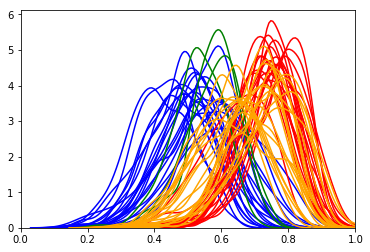

In [34]:
import matplotlib.pyplot as plt

for ttype in distances:
    if 'mag' in ttype:
        color = 'red'
    elif 'sag' in ttype:
        color = 'green'
    else:
        color = 'blue'
    sns.distplot(distances[ttype], hist=False, rug=False, color=color)

    
for ttype in distances_highqual:
    sns.distplot(distances_highqual[ttype], hist=False, rug=False, color='orange')

plt.savefig("gtdb2.svg", format="svg")

plt.xlim(0, 1)
plt.show()

In [20]:
## Read in calculated phylogenetic trees
trees = defaultdict(list)
for fn in glob.glob('../gtdb/trees/matched_genus/*/*.treefile'):
    scg = fn.split("/")[-1].split("_")[0]
    ttype = fn.split("/")[-1].split("_")[1].split(".")[0]
    trees[ttype].append(fn)

In [21]:
## Compare tree distances
distances_matched_genus = defaultdict(list)
for ttype in trees:
    for tree_pair in combinations(trees[ttype], 2):
        tree1 = Tree(tree_pair[0],quoted_node_names=True, format=1) 
        tree2 = Tree(tree_pair[1],quoted_node_names=True, format=1) 
        rf = tree1.robinson_foulds(tree2, unrooted_trees=True)
        if rf[1] != 0:
#             print(ttype + " RF distance is " + str(rf[0] / rf[1]))
            distances_matched_genus[ttype].append(rf[0] / rf[1])

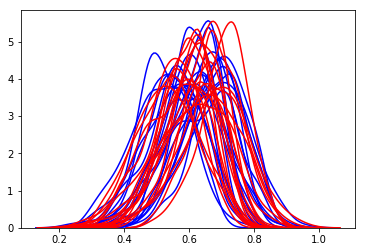

In [35]:
import matplotlib.pyplot as plt
for ttype in distances_matched_genus:
    if 'mag' in ttype:
        color = 'red'
    elif 'sag' in ttype:
        color = 'green'
    else:
        color = 'blue'
    sns.distplot(distances_matched_genus[ttype], hist=False, rug=False, color=color)

plt.savefig("gtdb3.svg", format="svg")

plt.show()

In [23]:
## Read in calculated phylogenetic trees
trees = defaultdict(list)
for fn in glob.glob('../gtdb/trees/matched_order/*/*.treefile'):
    scg = fn.split("/")[-1].split("_")[0]
    ttype = fn.split("/")[-1].split("_")[1].split(".")[0]
    trees[ttype].append(fn)

In [24]:
## Compare tree distances
distances_matched_order = defaultdict(list)
for ttype in trees:
    for tree_pair in combinations(trees[ttype], 2):
        tree1 = Tree(tree_pair[0],quoted_node_names=True, format=1) 
        tree2 = Tree(tree_pair[1],quoted_node_names=True, format=1) 
        rf = tree1.robinson_foulds(tree2, unrooted_trees=True)
        if rf[1] != 0:
#             print(ttype + " RF distance is " + str(rf[0] / rf[1]))
            distances_matched_order[ttype].append(rf[0] / rf[1])

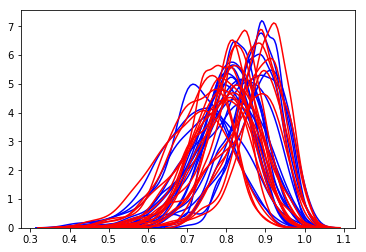

In [36]:
import matplotlib.pyplot as plt
for ttype in distances_matched_order:
    if 'mag' in ttype:
        color = 'red'
    elif 'sag' in ttype:
        color = 'green'
    else:
        color = 'blue'
    sns.distplot(distances_matched_order[ttype], hist=False, rug=False, color=color)

plt.savefig("gtdb4.svg", format="svg")
    
plt.show()